1. Is there a significant difference in daily sales counts between the UK and non-UK markets? [Go](#1)
2. Do total revenues in the UK vary significantly depending on the day of the week? [Go](#2)
3. Is there a difference in invoice amounts between clusters? (online_retail_clean_customer_clusters.csv) [Go](#3)
4. Does the average number of items sold per invoice differ between the UK and non-UK countries? [Go](#4)
5. Is there a difference in the invoice amounts of the first and second purchases of customers who make more than one purchase? [Go](#5)
6. Is there a difference in the invoice amounts of the first and second and third purchases of customers who make more than two purchase? [Go](#6)
7. Investigate whether the average total revenues on different days of the week differ for the top 5 countries with the highest sales outside the UK. [Go](#7)

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

In [1]:
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import matplotlib.pyplot as plt

In [2]:
α = alpha = 0.05

def decision(p, alpha=0.05, method=None):
    'acceptance or rejection of the null hypothesis'
    if method=='verbose':
        if p < alpha: return 'H0 rejected.'
        else: return 'H0 accepted.'
            
    if method=='sign':
        if p < alpha: return '✗'  # null hypothesis rejected
        else: return '✔'          # null hypothesis accepted
                
    if p < alpha: return True  # null hypothesis rejected
    else: return False         # null hypothesis accepted


def get_pairs(table):
    temp = table.melt(ignore_index=False).reset_index()
    temp = temp[temp['value']=='✗']
    temp = [list(temp.iloc[i, [0,1]].values) for i in range(len(temp.index))]

    pairs = set()
    for i, couple in enumerate(temp):
        couple.sort()
        pairs.add(f'{couple[0]} & {couple[1]}')

    return pairs

<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

##### **READ DATA**

In [3]:
data = pd.read_csv('data/online_retail_II_clean.csv', parse_dates=['InvoiceDate'])
data_backup = data.copy()
data.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
1,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50
2,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10


In [4]:
products = data[['StockCode', 'Description']].drop_duplicates(ignore_index=True)
display(products.tail(3))
data.drop(columns='Description', inplace=True)

,StockCode,Description
2512,23143,ZINC WIRE KITCHEN ORGANISER
2513,84679,CLASSICAL ROSE TABLE LAMP
2514,90089,PINK CRYSTAL SKULL PHONE CHARM


In [5]:
data['Day of Week'] = data['InvoiceDate'].dt.strftime('%A')
data['InvoiceDate'] = data['InvoiceDate'].dt.strftime('%m.%d.%Y')
display(data.sample(3))

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Day of Week
110538,556484,23298,6,06.12.2011,4.95,16938,United Kingdom,29.70,Sunday
10572,538203,22726,6,12.10.2010,3.75,13767,United Kingdom,22.50,Friday
31234,542419,22727,1,01.27.2011,3.75,14662,United Kingdom,3.75,Thursday


<a id='1'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **1. Is there a significant difference in daily sales counts between the UK and non-UK markets?**

| | |
|-|-|
| $H_0$ | **→** There is no significant difference in daily sales counts between the UK and non-UK markets. |
| $H_1$ | **→** There is a significant difference in daily sales counts between the UK and non-UK markets. |

In [6]:
df = data[['Country', 'InvoiceDate', 'Invoice']].copy()
df['Country'] = df['Country'].apply(lambda c: 'UK' if c=='United Kingdom' else 'Non-UK')

df = df.groupby(['Country', 'InvoiceDate']).agg({'Invoice':'nunique'}).reset_index()
display(df.tail(3))

df_1 = df[df['Country']=='UK']['Invoice']
df_2 = df[df['Country']=='Non-UK']['Invoice']

,Country,InvoiceDate,Invoice
589,UK,12.21.2010,18
590,UK,12.22.2010,9
591,UK,12.23.2010,11


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

,W,pval,normal
Country,,,
Non-UK,0.929486,1.989942e-10,False
UK,0.946861,4.870171e-09,False


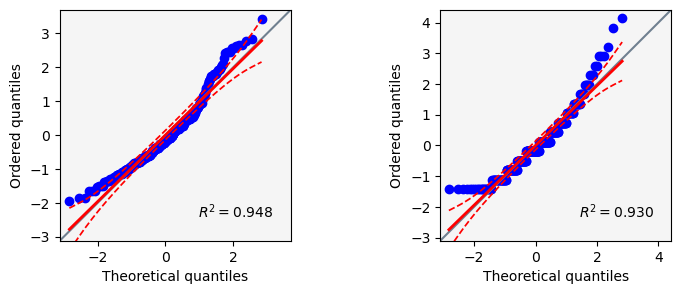

In [7]:
display(pg.normality(df, dv='Invoice', group='Country'))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,3))
pg.qqplot(df_1, ax=ax1)
pg.qqplot(df_2, ax=ax2)

ax1.set_facecolor('#f5f5f5')
ax2.set_facecolor('#f5f5f5')
plt.show()

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Homogeneity of Variance Test </p>

In [8]:
pg.homoscedasticity(df, dv='Invoice', group='Country', method='bartlett') #  method='levene'

,T,pval,equal_var
bartlett,654.904908,1.916004e-144,False


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Mann-Whitney U Test </p>

Since the assumptions of normality and homogeneity of variance are violated, we use the Mann-Whitney U Test instead of the Independent Samples T-Test or Welch T-test.

In [9]:
# test = pg.parametric.ttest(df_1, df_2, correction=False)
# test = pg.parametric.ttest(df_1, df_2, correction=True)
test = pg.nonparametric.mwu(df_1, df_2)
test['Reject'] = test[['p-val']].map(decision, method='verbose')
test

,U-val,alternative,p-val,RBC,CLES,Reject
MWU,87440.0,two-sided,4.993953e-98,0.997829,0.998915,H0 rejected.


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [10]:
df.groupby('Country')['Invoice'].agg(['mean', 'std']).round(2).T

Country,Non-UK,UK
mean,5.61,47.46
std,3.24,19.71


<a id='2'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **2. Do total revenues in the UK vary significantly depending on the day of the week?**

| | |
|-|-|
| $H_0$ | **→** There is no significant difference in total revenues in the UK based on the day of the week. |
| $H_1$ | **→** At least one day of the week has significantly different total revenues compared to the others. |

In [11]:
filt = data['Country']=='United Kingdom'
df = data[filt].copy()

df = df.groupby(['InvoiceDate', 'Day of Week']).agg({'Total':'sum'})
df = df.reset_index().drop(columns='InvoiceDate')
display(df.sample(3))

groups = df.groupby('Day of Week')
display(groups.size().to_frame().T)

,Day of Week,Total
36,Tuesday,6719.06
46,Sunday,4331.21
226,Monday,15626.35


Day of Week,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday
0,50,47,50,53,52,53


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

Day of Week,Tuesday,Wednesday,Thursday,Friday,Sunday,Monday
W,0.91638,0.938053,0.945421,0.887287,0.882883,0.887538
pval,0.001381,0.0085,0.017185,0.000188,0.000137,0.000295
normal,False,False,False,False,False,False


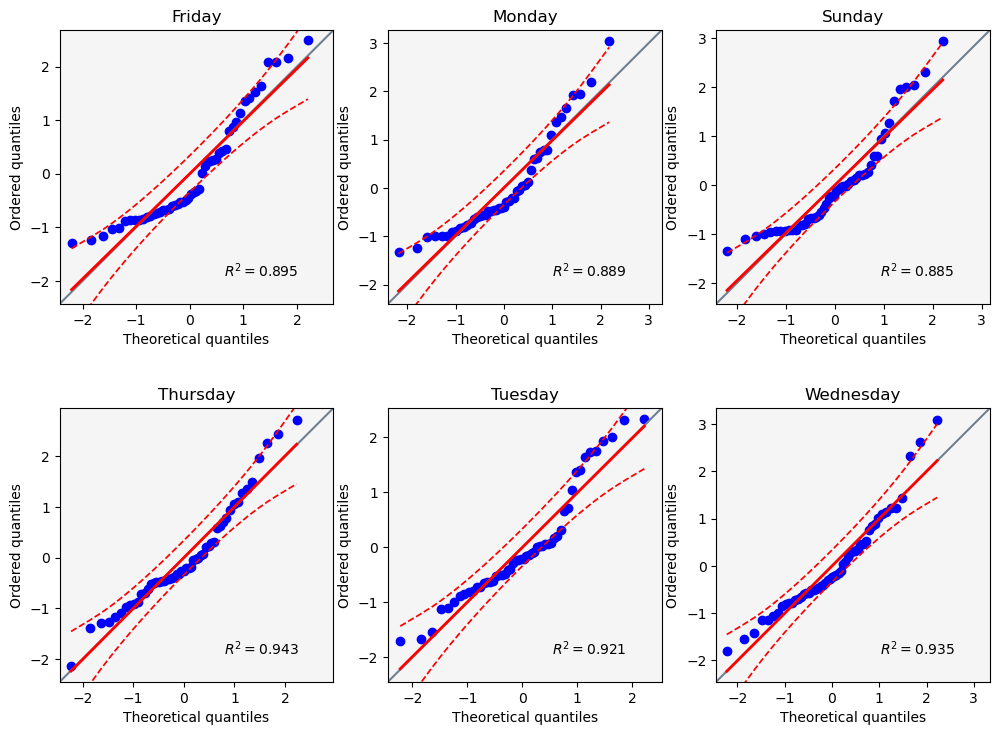

In [12]:
display(pg.normality(df, dv='Total', group='Day of Week').T)

fig, axs = plt.subplots(2,3, figsize=(12,9))
for c, (name, group) in enumerate(groups):
    i, j = c//3, c%3
    pg.qqplot(group['Total'], ax=axs[i,j])
    axs[i,j].set_title(name)
    axs[i,j].set_facecolor('#f5f5f5')

plt.show()

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Homogeneity of Variance Test </p>

In [13]:
pg.homoscedasticity(df, dv='Total', group='Day of Week', method='bartlett')

,T,pval,equal_var
bartlett,3.756003,0.585052,True


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; ANOVA Test</p>

One-way ANOVA can be applied by invoking the Central Limit Theorem. 

In [14]:
test = pg.parametric.anova(df, dv='Total', between='Day of Week')
# test = pg.parametric.welch_anova(df, dv='Total', between='Day of Week')
# test = pg.nonparametric.kruskal(df, dv='Total', between='Day of Week')
test['Reject'] = test[['p-unc']].map(decision, method='verbose')
test

,Source,ddof1,ddof2,F,p-unc,np2,Reject
0,Day of Week,5,299,5.438442,0.000083,0.083363,H0 rejected.


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Post-Hoc - Tukey HSD </p>

Since the variances are homogeneous and the sample sizes are similar across groups, the Tukey HSD test can be applied as a post hoc test.

In [15]:
# sp.posthoc_tukey_hsd(x=df['Total'], g=df['Day of Week'], alpha=0.05)

tukey_hsd = pg.pairwise_tukey(df, dv='Total', between='Day of Week')
tukey_hsd['Reject'] = tukey_hsd['p-tukey'].map(decision)

# display(tukey_hsd)
display(tukey_hsd[tukey_hsd['Reject']==True])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,Reject
2,Friday,Thursday,7925.8050,11083.513774,-3157.708774,817.941986,-3.860553,0.001912,-0.763270,True
9,Sunday,Thursday,7200.4826,11083.513774,-3883.031174,817.941986,-4.747319,0.000047,-0.864919,True


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [16]:
groups.mean().T.round()

Day of Week,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday
Total,7926.0,9587.0,7200.0,11084.0,9185.0,9120.0


<a id='3'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **3. Is there a difference in invoice amounts between clusters?** (online_retail_clean_customer_clusters.csv)

| | |
|-|-|
| $H_0$ | **→** There is no significant difference in invoice amounts based on customer groups. |
| $H_1$ | **→** At least one customer group has significantly different invoice amounts compared to the others. |

In [17]:
C = pd.read_csv('data/online_retail_clean_customer_clusters.csv', index_col='Customer ID')
display(C.value_counts().to_frame().T)
display(C.head().T)

Label,1,0,2,3
count,2016,1028,613,474


Customer ID,12347,12348,12349,12350,12352
Label,1,2,1,3,1


In [18]:
df = data[['Invoice', 'Customer ID', 'Total']]
df = df.groupby(['Customer ID', 'Invoice']).agg({'Total':'sum'})
df = df.reset_index().set_index('Invoice')

df['Group'] = df['Customer ID'].map(lambda id: C.loc[id, 'Label'])
df.drop(columns='Customer ID', inplace=True)
display(df.sample(3))

groups = df.groupby('Group')

,Total,Group
Invoice,,
549185,415.06,1
562619,124.02,1
566062,1.45,0


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

Group,1,2,3,0
W,10199.039821,432.492808,473.752964,2365.517597
pval,0.0,0.0,0.0,0.0
normal,False,False,False,False


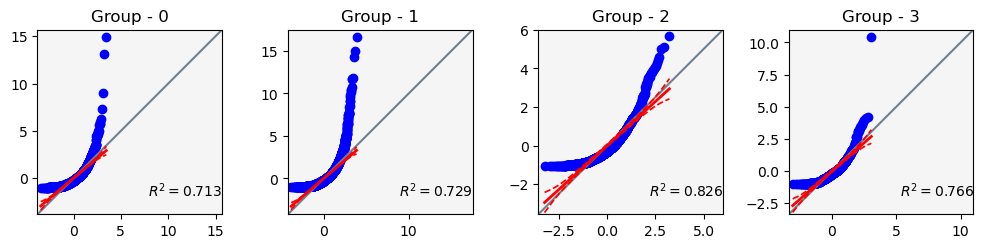

In [19]:
display(pg.normality(df, dv='Total', group='Group', method='normaltest').T)

fig, axs = plt.subplots(1,4, figsize=(10,3))
for i, (name, group) in enumerate(groups):
    pg.qqplot(group['Total'], ax=axs[i])
    axs[i].set_title(f'Group - {name}')
    axs[i].set_facecolor('#f5f5f5')
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)

plt.tight_layout()
plt.show()

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Homogeneity of Variance Test </p>

In [20]:
pg.homoscedasticity(df, dv='Total', group='Group', method='bartlett')

,T,pval,equal_var
bartlett,238.909868,1.637740e-51,False


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Kruskal-Wallis Test </p>

Since the assumptions of normality and homogeneity are not met, the Kruskal-Wallis test, which is the non-parametric equivalent of one-way ANOVA, is applied.

In [21]:
# test = pg.parametric.anova(df, dv='Total', between='Group')
# test = pg.parametric.welch_anova(df, dv='Total', between='Group')
test = pg.nonparametric.kruskal(df, dv='Total', between='Group')
test['Reject'] = test[['p-unc']].map(decision, method='verbose')
test

,Source,ddof1,H,p-unc,Reject
Kruskal,Group,3,111.589954,4.990487e-24,H0 rejected.


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Post-Hoc - Tamhane's T2 </p>

Since the variances are not homogeneous and the sample sizes are not similar across groups, the Tamhane's T2 test can be applied as a post hoc test.

In [22]:
tamhane = sp.posthoc_tamhane(df, val_col='Total', group_col='Group')
tamhane = tamhane.map(decision, method='sign') # ✗	→ Null Hypothesis Rejected
display(tamhane)

print(*get_pairs(tamhane), sep='\t')

,1,2,3,0
1,✔,✗,✗,✔
2,✗,✔,✔,✗
3,✗,✔,✔,✗
0,✔,✗,✗,✔


0 & 3	0 & 2	1 & 2	1 & 3


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [23]:
groups.mean().T.round(2)

Group,0,1,2,3
Total,208.03,203.43,163.46,153.57


<a id='4'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **4. Does the average number of items sold per invoice differ between the UK and non-UK countries?**


| | |
|-|-|
| $H_0$ | **→** There is no significant difference in the average number of items sold per invoice between the UK and non-UK countries. |
| $H_1$ | **→** There is a significant difference in the average number of items sold per invoice between the UK and non-UK countries. |

In [24]:
df = data[['Country', 'InvoiceDate', 'Invoice', 'Quantity']].copy()
df['Country'] = df['Country'].apply(lambda c: 'UK' if c=='United Kingdom' else 'Non-UK')

df = df.groupby(['Country', 'Invoice']).agg({'Quantity':'sum'})
df = df.reset_index().set_index('Invoice')
display(df.sample(3))

df_1 = df[df['Country']=='UK']['Quantity']
df_2 = df[df['Country']=='Non-UK']['Quantity']

,Country,Quantity
Invoice,,
577052,UK,121
546524,UK,29
555241,UK,3


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

,W,pval,normal
Country,,,
Non-UK,1149.450533,2.511818e-250,False
UK,11715.191318,0.000000e+00,False


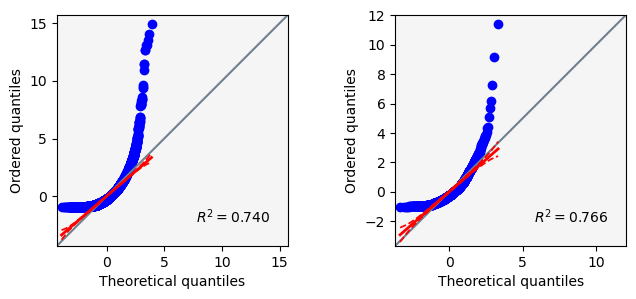

In [25]:
display(pg.normality(df, dv='Quantity', group='Country', method='normaltest')) # method='shapiro'

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
pg.qqplot(df_1, ax=ax1)
pg.qqplot(df_2, ax=ax2)

ax1.set_facecolor('#f5f5f5')
ax2.set_facecolor('#f5f5f5')
plt.show()

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Homogeneity of Variance Test </p>

In [26]:
pg.homoscedasticity(df, dv='Quantity', group='Country', method='bartlett')

,T,pval,equal_var
bartlett,485.158779,1.611451e-107,False


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Mann-Whitney U Test </p>

Since the assumptions of normality and homogeneity of variance are violated, we use the Mann-Whitney U Test instead of the Independent Samples T-Test.

In [27]:
# test = pg.parametric.ttest(df_1, df_2)
test = pg.nonparametric.mwu(df_1, df_2)
test['Reject'] = test[['p-val']].map(decision, method='verbose')
test

,U-val,alternative,p-val,RBC,CLES,Reject
MWU,8999844.5,two-sided,1.120344e-50,-0.227159,0.386421,H0 rejected.


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [28]:
df.groupby('Country')[['Quantity']].agg(['mean', 'std']).round(2).T

Country        Non-UK      UK
Quantity mean  186.39  124.11
         std   185.91  128.28

<a id='5'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **5. Is there a difference in the invoice amounts of the first and second purchases of customers who make more than one purchase?**

| | |
|-|-|
| $H_0$ | **→** There is no significant difference in the invoice amounts of the first and second purchases of customers who make more than one purchase. |
| $H_1$ | **→** There is a significant difference in the invoice amounts of the first and second purchases of customers who make more than one purchase. |

In [29]:
temp = data.groupby('Customer ID')['Invoice'].nunique()!=1
more_than_one_purchase_id = temp[temp].index # ==True

df = data[data['Customer ID'].isin(more_than_one_purchase_id)]
df = df[['Invoice', 'InvoiceDate', 'Customer ID', 'Total']]

df = df.groupby(['Customer ID', 'Invoice', 'InvoiceDate'])[['Total']].sum()
df = df.reset_index()

df['count'] = df.groupby('Customer ID').cumcount() + 1
df = df[df['count'] <= 2].drop(columns=['count', 'Invoice'])

df = df.sort_values(by=['Customer ID', 'InvoiceDate'], ignore_index=True)
df['Time'] = df.index.map(lambda i: 'First' if i%2==0 else 'Second')
df.drop(columns=['InvoiceDate'], inplace=True)

df = df[['Customer ID', 'Time', 'Total']]
display(df.head(4))

_df = df.pivot(columns='Time', values='Total', index='Customer ID')
_df['Difference'] = _df['First']-_df['Second']
# display(_df.head(4))

,Customer ID,Time,Total
0,12347,First,348.44
1,12347,Second,402.94
2,12348,First,20.40
3,12348,Second,52.80


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

,W,pval,normal
Difference,0.89032,8.238984e-40,False


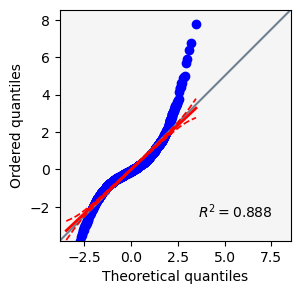

In [30]:
display(pg.normality(_df['Difference']))

pg.qqplot(_df['Difference'])
plt.gca().set_facecolor('#f5f5f5')
plt.gcf().set_size_inches(4,3)
plt.show()

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Wilcoxon Test </p>

Since the assumptions of normality is violated, we use the Wilcoxon Test instead of the Dependent Samples T-Test.

In [31]:
# test = pg.parametric.ttest(_df['First'], _df['Second'], paired=True)
test = pg.nonparametric.wilcoxon(_df['First'], _df['Second']) # _df['Difference']
test['Reject'] = test[['p-val']].map(decision, method='verbose')
test

,W-val,alternative,p-val,RBC,CLES,Reject
Wilcoxon,1293361.5,two-sided,1.274596e-28,0.250062,0.567636,H0 rejected.


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [32]:
df.groupby('Time')['Total'].agg(['mean', 'std']).round(2).T

Time,First,Second
mean,224.92,188.40
std,194.65,173.39


<a id='6'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **6. Is there a difference in the invoice amounts of the first and second and third purchases of customers who make more than two purchase?**

| | |
|-|-|
| $H_0$ | **→** There is no significant difference in the invoice amounts of the first, second, and third purchases of customers who make more than two purchases. |
| $H_1$ | **→** At least one invoice amount among the first, second, and third purchases of customers who make more than two purchases is significantly different from the others. |

In [33]:
temp = data.groupby('Customer ID')['Invoice'].nunique()>2
more_than_one_purchase_id = temp[temp].index # ==True

df = data[data['Customer ID'].isin(more_than_one_purchase_id)]
df = df[['Invoice', 'InvoiceDate', 'Customer ID', 'Total']]

df = df.groupby(['Customer ID', 'Invoice', 'InvoiceDate'])[['Total']].sum()
df = df.reset_index()

df['count'] = df.groupby(['Customer ID']).cumcount() + 1
df = df[df['count'] <= 3].drop(columns=['count', 'Invoice'])

df = df.sort_values(by=['Customer ID', 'InvoiceDate'], ignore_index=True)

def _f(n):
    if n%3==0: return 'First' 
    if n%3==1: return 'Second' 
    return 'Third'
    
df['Time'] = df.index.map(_f)
df.drop(columns=['InvoiceDate'], inplace=True)
df = df[['Customer ID', 'Time', 'Total']]
display(df.head(4))

_df = df.pivot(columns='Time', values='Total', index='Customer ID')
# display(_df.head(4))

,Customer ID,Time,Total
0,12347,First,348.44
1,12347,Second,304.60
2,12347,Third,402.94
3,12348,First,20.40


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

,W,pval,normal
Time,,,
First,1235.554043,5.044853e-269,False
Second,1151.697830,8.165708e-251,False
Third,920.740573,1.158044e-200,False


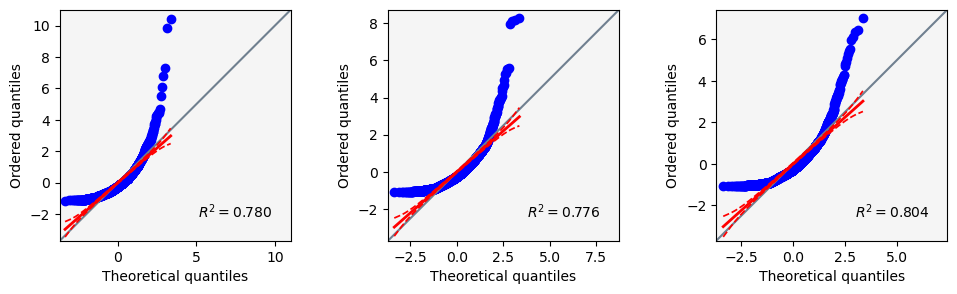

In [34]:
display(pg.normality(df, dv='Total', group='Time', method='normaltest'))


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
pg.qqplot(_df['First'], ax=ax1)
pg.qqplot(_df['Second'], ax=ax2)
pg.qqplot(_df['Third'], ax=ax3)

ax1.set_facecolor('#f5f5f5')
ax2.set_facecolor('#f5f5f5')
ax3.set_facecolor('#f5f5f5')
plt.show()

<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Homogeneity of Variance Test </p>

The homogeneity test is not an assumption for repeated measures ANOVA, but a necessary parameter for selecting the post hoc test.

In [35]:
pg.homoscedasticity(df, dv='Total', group='Time')

,W,pval,equal_var
levene,5.255877,0.005243,False


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Sphericity Test </p>

In [36]:
sphericity = pg.sphericity(df, dv='Total', subject='Customer ID', within='Time')
print('Decision :', decision(sphericity.pval, method='verbose'))
print('P value  :', round(sphericity.pval, 4))

Decision : H0 rejected.
P value  : 0.0059


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Friedman Test </p>

Since the assumptions of normality and sphericity are violated, the Friedman test, which is the non-parametric equivalent of repeated measures ANOVA, is applied.

In [37]:
# test = pg.parametric.rm_anova(df, dv='Total', within='Time', subject='Customer ID', correction=True)
test = pg.nonparametric.friedman(df, dv='Total', within='Time', subject='Customer ID')
test['Reject'] = test[['p-unc']].map(decision, method='verbose')
test

,Source,W,ddof1,Q,p-unc,Reject
Friedman,Time,0.023623,2,85.280334,3.031174e-19,H0 rejected.


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Post-Hoc - Conover | Tamhane's T2 </p>

Since the variances are not homogeneous and the sample sizes are not similar across groups, the Tamhane's T2 test can be applied as a post hoc test. Also Conover test is usually conducted post hoc after significant results of the Friedman test.

In [38]:
conover = sp.posthoc_conover_friedman(df, group_col='Time',  
                            y_col='Total', block_col='Customer ID', 
                            melted=True, p_adjust='bonf')
conover = conover.map(decision, method='sign') # ✗	→ Null Hypothesis Rejected
display(conover)
print(*get_pairs(conover), sep='\t')


# tamhane = sp.posthoc_tamhane(df, val_col='Total', group_col='Time')
# tamhane = tamhane.map(decision, method='sign') # ✗	→ Null Hypothesis Rejected
# display(tamhane)
# print(*get_pairs(tamhane), sep='\t')

,First,Second,Third
First,✔,✗,✗
Second,✗,✔,✔
Third,✗,✔,✔


First & Third	First & Second


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [39]:
df.groupby('Time')[['Total']].agg(['mean', 'std']).T

Time             First      Second       Third
Total mean  235.050078  202.202122  189.046770
      std   204.004705  186.531855  175.357824

<a id='7'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>

#####  **7. Investigate whether the average total revenues on different days of the week differ for the top 5 countries with the highest sales outside the UK.**

| | |
|-|-|
| $H_0$ | **→**  There is no significant difference in average total revenues between the days of the week, between the countries, or in the interaction between days of the week and countries. |
| $H_1$ | **→** There is at least one significant difference in average total revenues between the days of the week, between the countries, or in the interaction between days of the week and countries. |

In [40]:
countries = data.groupby('Country')['Invoice'].nunique().nlargest(6)[1:] # first one is UK
filt = data['Country'].isin(countries.index)

df = data.loc[filt, ['Invoice', 'Country', 'Day of Week', 'Total']]
# display(df.sample(5))

df = df.groupby(['Invoice', 'Country', 'Day of Week'])[['Total']].sum()
df = df.reset_index()   # .drop(columns='Invoice')

df['Interaction'] = df['Country'] + ' & ' + df['Day of Week']
# display(df['Interaction'].value_counts())
print('Interaction Count:', df['Interaction'].nunique())

display(df.sample(5))

Interaction Count: 30


,Invoice,Country,Day of Week,Total,Interaction
2,536540,EIRE,Wednesday,133.08,EIRE & Wednesday
952,574255,Germany,Thursday,74.25,Germany & Thursday
780,567968,Spain,Friday,640.78,Spain & Friday
991,575735,EIRE,Friday,176.50,EIRE & Friday
790,568221,EIRE,Monday,314.98,EIRE & Monday


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Normality Test </p>

In [41]:
display(pg.normality(df, dv='Total', group='Country'))
display(pg.normality(df, dv='Total', group='Day of Week'))
# display(pg.normality(df, dv='Total', group='Interaction'))

,W,pval,normal
Country,,,
France,0.656567,4.119507e-26,False
Germany,0.834727,2.071083e-20,False
EIRE,0.931325,9.933405e-09,False
Belgium,0.922768,4.111517e-05,False
Spain,0.814640,1.252889e-08,False


,W,pval,normal
Day of Week,,,
Wednesday,0.865026,7.249254e-13,False
Thursday,0.821194,5.546821e-17,False
Friday,0.861519,2.309300e-13,False
Sunday,0.812436,1.053711e-09,False
Monday,0.882585,5.830693e-11,False
Tuesday,0.582012,3.191226e-20,False


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Homogeneity of Variance Test </p>

In [42]:
homogeneity_c = pg.homoscedasticity(df, dv='Total', group='Country', method='bartlett')
homogeneity_d = pg.homoscedasticity(df, dv='Total', group='Day of Week', method='bartlett')
homogeneity_i = pg.homoscedasticity(df, dv='Total', group='Interaction', method='bartlett')

homogeneity = pd.concat([homogeneity_c, homogeneity_d, homogeneity_i])
homogeneity['Factor'] = ['Country', 'Day of Week', 'Interaction']
display(homogeneity)

,T,pval,equal_var,Factor
bartlett,28.430643,1.020106e-05,False,Country
bartlett,19.610656,1.478346e-03,False,Day of Week
bartlett,141.922579,7.891712e-17,False,Interaction


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Two-Way ANOVA Test </p>

*In many applications with a moderate or larger sample size, a two-way ANOVA may yield reasonably accurate p values even when the normality assumption is violated. In some applications with nonnormal populations, a sample size of 15 cases per group might be sufficiently large to yield fairly accurate p values. **(Green and Salkind, 2014)***

In [43]:
# test = pg.anova(data=df, dv='Total', between=['Country',  'Day of Week'])

test1 = pg.welch_anova(data=df, dv='Total', between='Country')
test2 = pg.welch_anova(data=df, dv='Total', between='Day of Week')
test3 = pg.welch_anova(data=df, dv='Total', between='Interaction')
test = pd.concat([test1, test2, test3])

# test1 = pg.kruskal(data=df, dv='Total', between='Country')
# test2 = pg.kruskal(data=df, dv='Total', between='Day of Week')
# test3 = pg.kruskal(data=df, dv='Total', between='Interaction')
# test = pd.concat([test1, test2, test3])

test['Reject'] = test['p-unc'].map(decision)
display(test)

,Source,ddof1,ddof2,F,p-unc,np2,Reject
0,Country,4,320.043563,4.669125,0.001124,0.016323,True
0,Day of Week,5,462.192285,0.693912,0.628265,0.002692,False
0,Interaction,29,214.277275,1.479266,0.062215,0.037464,False


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Post-Hoc Test </p>

Since the country variable is the only one showing a significant effect in the analysis, post hoc tests (e.g., Tamhane's T2 or Games-Howell) will be applied solely to the country variable to identify specific group differences. Post hoc testing for other factors is not necessary, as no significant effects were found for those variables.

In [44]:
tamhane = sp.posthoc_tamhane(df, val_col='Total', group_col='Country') # 'Day of Week' 'Interaction'
tamhane = tamhane.map(decision, method='sign') # ✗	→ Null Hypothesis Rejected
# display(tamhane)
print(*get_pairs(tamhane), sep='\t')

games_howell = pg.pairwise_gameshowell(df, dv='Total', between='Country')  # 'Day of Week' 'Interaction'
games_howell['Reject'] = games_howell['pval'].map(decision)
# display(games_howell)
display(games_howell[games_howell['Reject']==True])

EIRE & France	EIRE & Germany	Belgium & EIRE


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,Reject
0,Belgium,EIRE,263.483587,338.290893,-74.807306,25.107858,-2.979438,245.984094,0.026139,-0.314859,True
4,EIRE,France,338.290893,272.878616,65.412277,22.287561,2.934923,484.708556,0.028681,0.248611,True
5,EIRE,Germany,338.290893,253.116779,85.174114,20.587864,4.137103,413.013777,0.000409,0.354721,True


<p style="background-image: linear-gradient(#0aa98f, #ffffff 10%); font-weight:bold;"> 
    &nbsp; Display of Metrics </p>

In [45]:
display(df.groupby('Country')['Total'].mean().to_frame().T)
# display(df.groupby('Day of Week')['Total'].mean().to_frame().T)

# temp = df.groupby(['Country', 'Day of Week'])['Total'].mean().to_frame().T
# temp = temp.melt().pivot(columns='Day of Week', index='Country', values='value')
# display(temp)

Country,Belgium,EIRE,France,Germany,Spain
Total,263.483587,338.290893,272.878616,253.116779,308.152625


<a id='END'></a>
<p style="background-image: linear-gradient(to right, #0aa98f, #68dab2)"> &nbsp; </p>